In [338]:
#import libraries
import pandas as pd
from cStringIO import StringIO
import tensorflow as tf
import numpy as np
import sklearn
from sklearn import cross_validation
from sklearn import svm
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split
import pandas as pd
import tensorflow as tf
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)


In [282]:
#check files in google cloud storage
%%storage list --bucket gs://happiness-incentro

Name,Type,Size,Updated
Happines.csv,text/csv,3386,2016-12-12 09:29:21.068000+00:00
boston_predict.csv,text/csv,342,2016-12-12 14:10:46.761000+00:00
boston_test.csv,text/csv,5536,2016-12-12 14:10:46.770000+00:00
boston_train.csv,text/csv,22044,2016-12-12 14:10:46.811000+00:00
gegevenstotaal.csv,text/csv,208721,2016-12-12 09:29:21.049000+00:00
geluk.csv,text/csv,22656,2016-12-12 10:12:42.998000+00:00


In [283]:
#read file
%%storage read --object gs://happiness-incentro/geluk.csv --variable geluktotaal

In [284]:
#write file to panda dataframe
geluk=pd.read_csv(StringIO(geluktotaal), sep=",")

In [285]:
#select variables for use
geluk = geluk.loc[:,['Life.Ladder',
       'Log.GDP.per.capita', 'Social.support',
       'Healthy.life.expectancy.at.birth', 'Freedom.to.make.life.choices',
       'Generosity', 'Perceptions.of.corruption', 'Positive.affect',
       'Negative.affect', 'Confidence.in.national.government',
       'Democratic.Quality', 'Delivery.Quality',
       'Mean']]

In [286]:
#check on dataframe
geluk.head()

,Life.Ladder,Log.GDP.per.capita,Social.support,Healthy.life.expectancy.at.birth,Freedom.to.make.life.choices,Generosity,Perceptions.of.corruption,Positive.affect,Negative.affect,Confidence.in.national.government,Democratic.Quality,Delivery.Quality,Mean
0,6.697131,9.805691,0.926492,67.287224,0.881224,-0.168666,0.850906,0.858544,0.305355,0.378169,0.184472,-0.686682,7.1
1,4.348320,8.968936,0.722551,65.300758,0.551027,-0.186697,0.901462,0.594143,0.437948,0.170928,-0.378111,-0.178475,4.9
2,7.309061,10.680326,0.951862,72.560242,0.921871,0.315702,0.356554,0.790050,0.209637,0.478557,1.228348,1.814433,7.6
3,7.076447,10.691354,0.928110,70.822556,0.900305,0.089089,0.557480,0.798263,0.164469,0.454790,1.353560,1.613224,7.2
4,5.146775,9.730904,0.785703,61.975845,0.764289,-0.222635,0.615553,0.606569,0.206114,0.788487,-0.970333,-0.539710,5.8


In [287]:
#Label columns, features and target
COLUMNS = ['Life.Ladder',
       'Log.GDP.per.capita', 'Social.support',
       'Healthy.life.expectancy.at.birth', 'Freedom.to.make.life.choices',
       'Generosity', 'Perceptions.of.corruption', 'Positive.affect',
       'Negative.affect', 'Confidence.in.national.government',
       'Democratic.Quality', 'Delivery.Quality',
       'Mean']
FEATURES = ['Life.Ladder',
       'Log.GDP.per.capita', 'Social.support',
       'Healthy.life.expectancy.at.birth', 'Freedom.to.make.life.choices',
       'Generosity', 'Perceptions.of.corruption', 'Positive.affect',
       'Negative.affect', 'Confidence.in.national.government',
       'Democratic.Quality', 'Delivery.Quality']
LABEL ='Mean'

In [288]:
# create training and test set for Tensorflow
training_set, test_set = train_test_split(geluk, test_size = 0.5, random_state=12)

In [289]:
# create training and test sets for SVM
y_test=test_set.loc[:,'Mean']
y_train=training_set.loc[:,'Mean']
X_test=test_set.iloc[:,:12]
X_train=training_set.iloc[:,:12]

In [446]:
# SVM linear kernel
svmL = svm.LinearSVR(C=0.07)
svmL.fit(X_train, y_train)  
y_predL = svmL.predict(X_test)
r2SVML=r2_score(y_test, y_predL)

# SVM radial kernel
svmR = svm.SVR(kernel='rbf', gamma=0.005, C=5)
svmR.fit(X_train, y_train)  
y_predR = svmR.predict(X_test)
r2SVMR=r2_score(y_test, y_predR)

In [291]:
#Define columns as real values (no categories in this dataset)
feature_cols = [tf.contrib.layers.real_valued_column(k)
                  for k in FEATURES]

In [292]:
#Set the DNN
regressor = tf.contrib.learn.DNNRegressor(
    feature_columns=feature_cols, hidden_units=[200, 140,40])

In [293]:
#write function for setting the Tensors
def input_fn(data_set):
  feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
  labels = tf.constant(data_set[LABEL].values)
  return feature_cols, labels

In [294]:
# Run the DNN
regressor.fit(input_fn=lambda: input_fn(training_set), steps = 147301)

DNNRegressor(hidden_units=[200, 140, 40], dropout=None, optimizer=None, feature_columns=[_RealValuedColumn(column_name='Life.Ladder', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Log.GDP.per.capita', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Social.support', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Healthy.life.expectancy.at.birth', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Freedom.to.make.life.choices', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Generosity', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Perceptions.of.corruption', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='Positive.affect', dim

In [295]:
# Build the evaluation for the DNN on the test set
ev = regressor.evaluate(input_fn=lambda: input_fn(test_set), steps=1500)

In [296]:
# Print loss score
loss_score = ev["loss"]
print("Loss: {0:f}".format(loss_score))

Loss: 0.498901


In [297]:
# predict with DNN
y = regressor.predict(input_fn=lambda: input_fn(test_set))
r2DNN=r2_score(test_set.Mean, y)

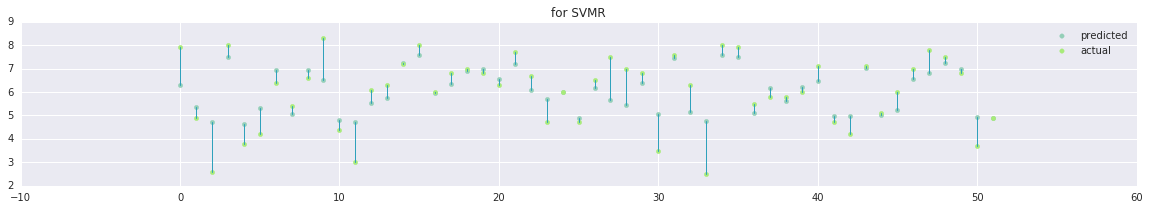

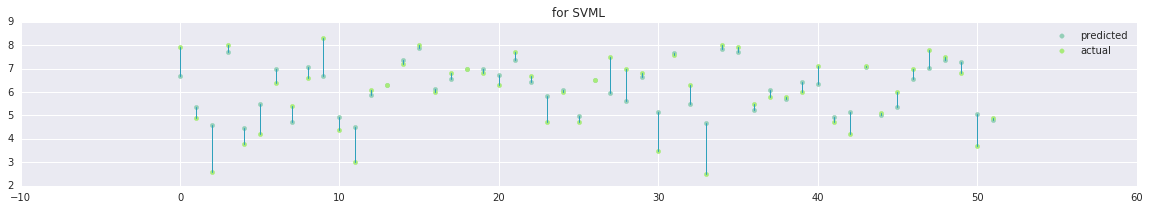

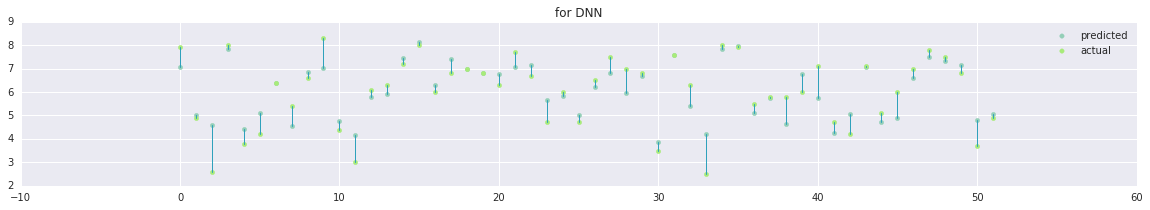

In [463]:
# Create plots for SVMR, SVML and DNN
#SVMR
x_as = np.arange(len(y))
ar2 = zip(y_predR,y_test)
ar1 = zip(x_as,x_as)

fig = plt.figure(figsize=(20,10))
plt.subplot(311)

for i in range(len(ar1)):
    plt.plot(ar1[i], ar2[i], 'k-', lw=1, color='#2fa1bc')
plot_pred = plt.scatter(x_as, y_predR, color="#94cfb8")
plot_test = plt.scatter(x_as,y_test, color="#a8eb7a")
plt.title("for SVMR")
plt.legend([plot_pred,plot_test], ["predicted","actual"])

#SVML
x_as = np.arange(len(y))
ar2 = zip(y_predL,y_test)
ar1 = zip(x_as,x_as)

fig = plt.figure(figsize=(20,10))
plt.subplot(312)

for i in range(len(ar1)):
    plt.plot(ar1[i], ar2[i], 'k-', lw=1, color='#2fa1bc')
plot_pred = plt.scatter(x_as, y_predL, color="#94cfb8")
plot_test = plt.scatter(x_as,y_test, color="#a8eb7a")
plt.title("for SVML")
plt.legend([plot_pred,plot_test], ["predicted","actual"])

#DNN
x_as = np.arange(len(y))
ar2 = zip(y,y_test)
ar1 = zip(x_as,x_as)

fig = plt.figure(figsize=(20,10))
plt.subplot(313)

for i in range(len(ar1)):
    plt.plot(ar1[i], ar2[i], '-', lw=1, color='#2fa1bc')
plot_pred = plt.scatter(x_as, y, color="#94cfb8")
plot_test = plt.scatter(x_as,y_test, color="#a8eb7a")
plt.title("for DNN")
plt.legend([plot_pred,plot_test], ["predicted","actual"])
plt.show()

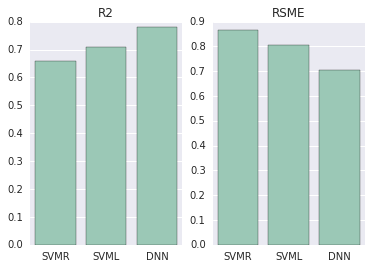

In [457]:
#R2
list=[]
list.append(np.round(r2SVMR,decimals=2))
list.append(np.round(r2SVML,decimals=2))
list.append(np.round(r2DNN,decimals=2))

plt.subplots(nrows=1,ncols=2)
plt.subplot(121)
x_as=["SVMR","SVML","DNN"]
sns.barplot(x_as,list, color="#94cfb8")
plt.title("R2")

#RMSE 
RSMER=np.sqrt(np.mean(pow((y_predR - y_test),2)))
RSMEL=np.sqrt(np.mean(pow((y_predL - y_test),2)))
RSMEDNN=np.sqrt(np.mean(pow((y - y_test),2)))
list2=[]
list2.extend((RSMER,RSMEL,RSMEDNN))

plt.subplot(1,2,2)
x_as=["SVMR","SVML","DNN"]
sns.barplot(x_as,list2, color="#94cfb8")
plt.title("RSME")
plt.show()


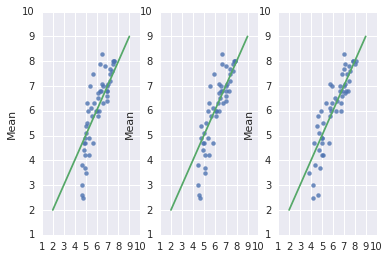

In [483]:
plt.subplot(1,3,1)
sns.regplot(y_predR,y_test, fit_reg=False)
plt.plot([2,9],[2,9])

plt.subplot(1,3,2)
sns.regplot(y_predL,y_test, fit_reg=False)
plt.plot([2,9],[2,9])

plt.subplot(1,3,3)
sns.regplot(y,y_test, fit_reg=False)
plt.plot([2,9],[2,9])

plt.show()
